# Пробуем класс на основе Prophet

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os

class RetailSalesPredictor:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data

    def preprocess_data(self, store_id, item_id):
        sales = self.sales_data[(self.sales_data['store_id'] == store_id) & (self.sales_data['item_id'] == item_id)]
        sales = pd.merge(sales, self.calendar_data, on='date_id', how='inner')
        sales = sales.rename(columns={'date': 'ds', 'cnt': 'y'})
        sales['ds'] = pd.to_datetime(sales['ds'])

        holidays_1 = self.calendar_data[['date', 'event_name_1']].dropna().rename(columns={'date': 'ds', 'event_name_1': 'holiday'})
        holidays_2 = self.calendar_data[['date', 'event_name_2']].dropna().rename(columns={'date': 'ds', 'event_name_2': 'holiday'})
        holidays = pd.concat([holidays_1, holidays_2])
        holidays['ds'] = pd.to_datetime(holidays['ds'])

        future_years = [2024, 2025]
        future_holidays = []
        for year in future_years:
            for holiday in holidays['holiday'].unique():
                future_holidays.append({
                    'holiday': holiday,
                    'ds': pd.to_datetime(f"{year}-01-01"),
                    'lower_window': 0,
                    'upper_window': 1
                })
        future_holidays_df = pd.DataFrame(future_holidays)
        all_holidays = pd.concat([holidays, future_holidays_df])

        item_prices = self.prices_data[self.prices_data['item_id'] == item_id][['wm_yr_wk', 'sell_price']]
        item_prices['wm_yr_wk'] = item_prices['wm_yr_wk'].astype(int)
        item_prices = item_prices.rename(columns={'wm_yr_wk': 'week', 'sell_price': 'price'})
        self.calendar_data['wm_yr_wk'] = self.calendar_data['wm_yr_wk'].astype(int)
        item_prices = item_prices.merge(self.calendar_data[['wm_yr_wk', 'date']], left_on='week', right_on='wm_yr_wk', how='left')
        item_prices = item_prices.rename(columns={'date': 'ds'}).drop(columns=['wm_yr_wk'])
        item_prices['ds'] = pd.to_datetime(item_prices['ds'])

        # Handling missing values in price column
        item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values

        sales = sales.merge(item_prices[['ds', 'price']], on='ds', how='left')

        return sales, all_holidays

    def train_model(self, sales_data, holidays, test_size=30):
        if len(sales_data) <= test_size:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        train_data = sales_data.iloc[:-test_size]
        test_data = sales_data.iloc[-test_size:]

        if len(train_data) < 2:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.add_regressor('price')
        model.fit(train_data)

        return model, train_data, test_data

    def predict_and_evaluate(self, model, sales_data, test_data):
        future = model.make_future_dataframe(periods=len(test_data))
        future = future.merge(sales_data[['ds', 'price']], on='ds', how='left')

        forecast = model.predict(future)
        predicted = forecast[['ds', 'yhat']].tail(len(test_data))

        actual = test_data['y'].values
        predicted_values = predicted['yhat'].values

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)
        r2 = r2_score(actual, predicted_values)

        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'R²: {r2}')

        fig1 = model.plot(forecast)
        plt.show()

        fig2 = model.plot_components(forecast)
        plt.show()

        # Визуализация тестовой части и предсказанных данных
        plt.figure(figsize=(10, 6))
        plt.plot(test_data['ds'], actual, label='Actual', marker='o')
        plt.plot(predicted['ds'], predicted_values, label='Predicted', marker='x')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

        return mse, mae, r2

    def save_model(self, model, filename):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model

    def forecast_period(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        available_data = len(sales_data)
        test_size = min(period, available_data - 2)  # Убедимся, что у нас достаточно данных для тренировки и тестирования
        if test_size < 1:
            raise ValueError("Not enough data to train the model for this period. Please provide more data.")
        model, train_data, test_data = self.train_model(sales_data, holidays, test_size=test_size)
        mse, mae, r2 = self.predict_and_evaluate(model, sales_data, test_data)
        return model, mse, mae, r2

    def forecast_future(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        if len(sales_data) < 2:
            raise ValueError("Not enough data to forecast the future.")
        
        # Fill NaN values in the 'price' column
        sales_data['price'].fillna(method='ffill', inplace=True)
        
        train_data = sales_data.copy()
        model = Prophet(holidays=holidays)
        model.add_regressor('price')
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=period)
        future = future.merge(sales_data[['ds', 'price']], on='ds', how='left')
        
        # Fill NaN values in the 'price' column in future data
        future['price'].fillna(method='ffill', inplace=True)
        
        forecast = model.predict(future)
        predicted = forecast[['ds', 'yhat']].tail(period)
        
        return predicted

    def forecast_week(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=7)

    def forecast_month(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=30)

    def forecast_quarter(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=90)

    def predict_week(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=7)

    def predict_month(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=30)

    def predict_quarter(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=90)


In [7]:
sales_data[sales_data['store_id'] == 'STORE_1']['item_id'].unique()

array(['STORE_1_064', 'STORE_1_065', 'STORE_1_325', 'STORE_1_376',
       'STORE_1_090', 'STORE_1_252', 'STORE_1_339', 'STORE_1_546',
       'STORE_1_547', 'STORE_1_555', 'STORE_1_584', 'STORE_1_586',
       'STORE_1_587', 'STORE_1_714', 'STORE_1_727'], dtype=object)

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
19:19:09 

Mean Squared Error: 1.8030851798299328
Mean Absolute Error: 1.138061710625794
R²: -0.6361328483641979


/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


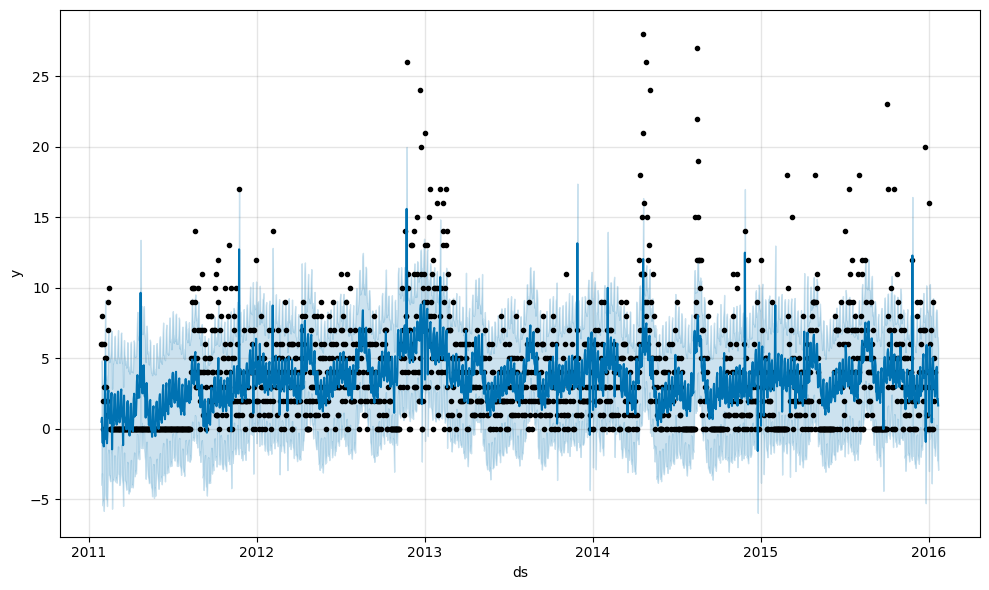

/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

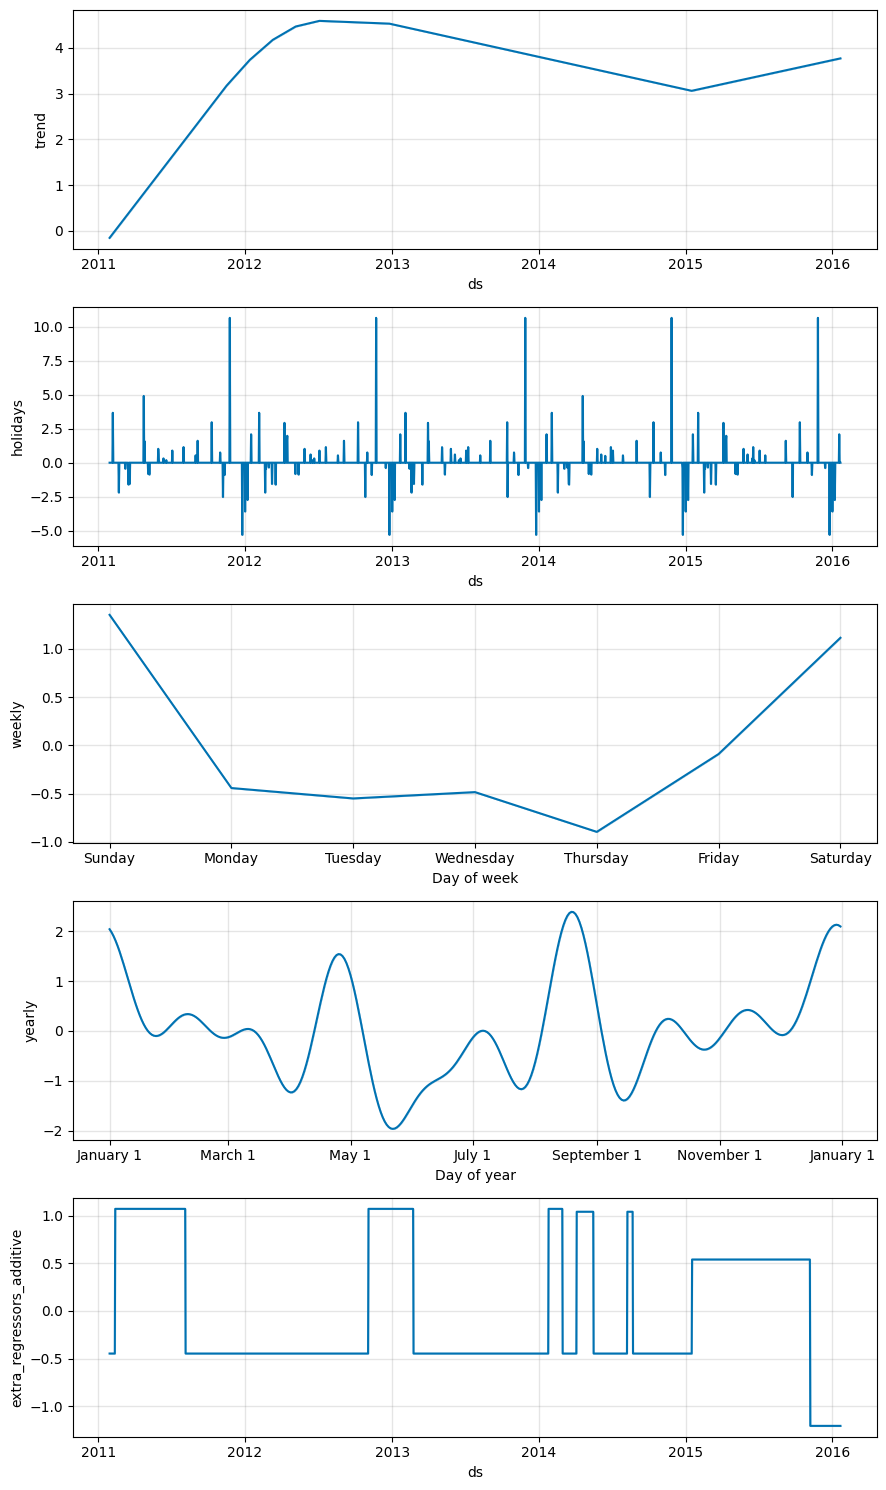

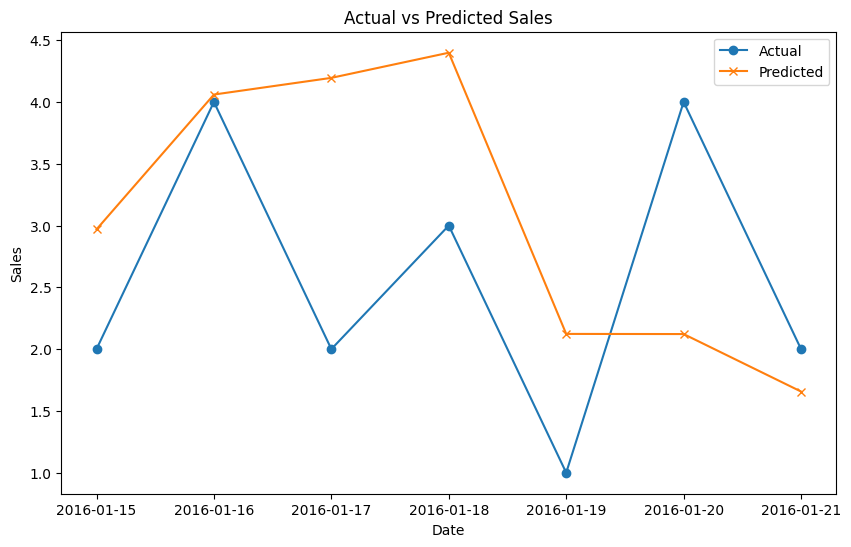

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
19:19:10 

Week - MSE: 1.8030851798299328, MAE: 1.138061710625794, R²: -0.6361328483641979


19:19:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 20.34673469744964
Mean Absolute Error: 2.7611247853558996
R²: -0.032014271173618436


/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


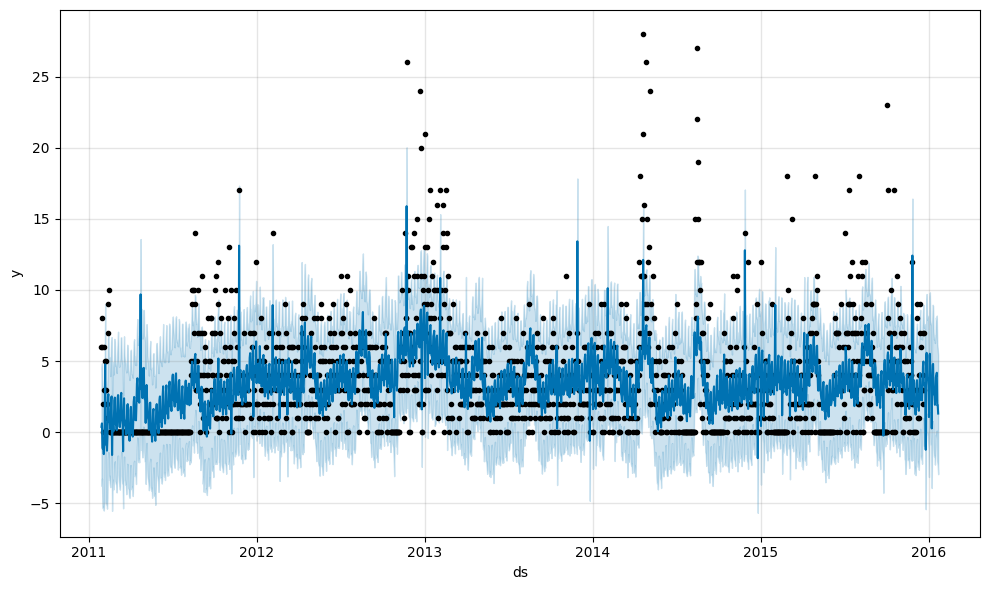

/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

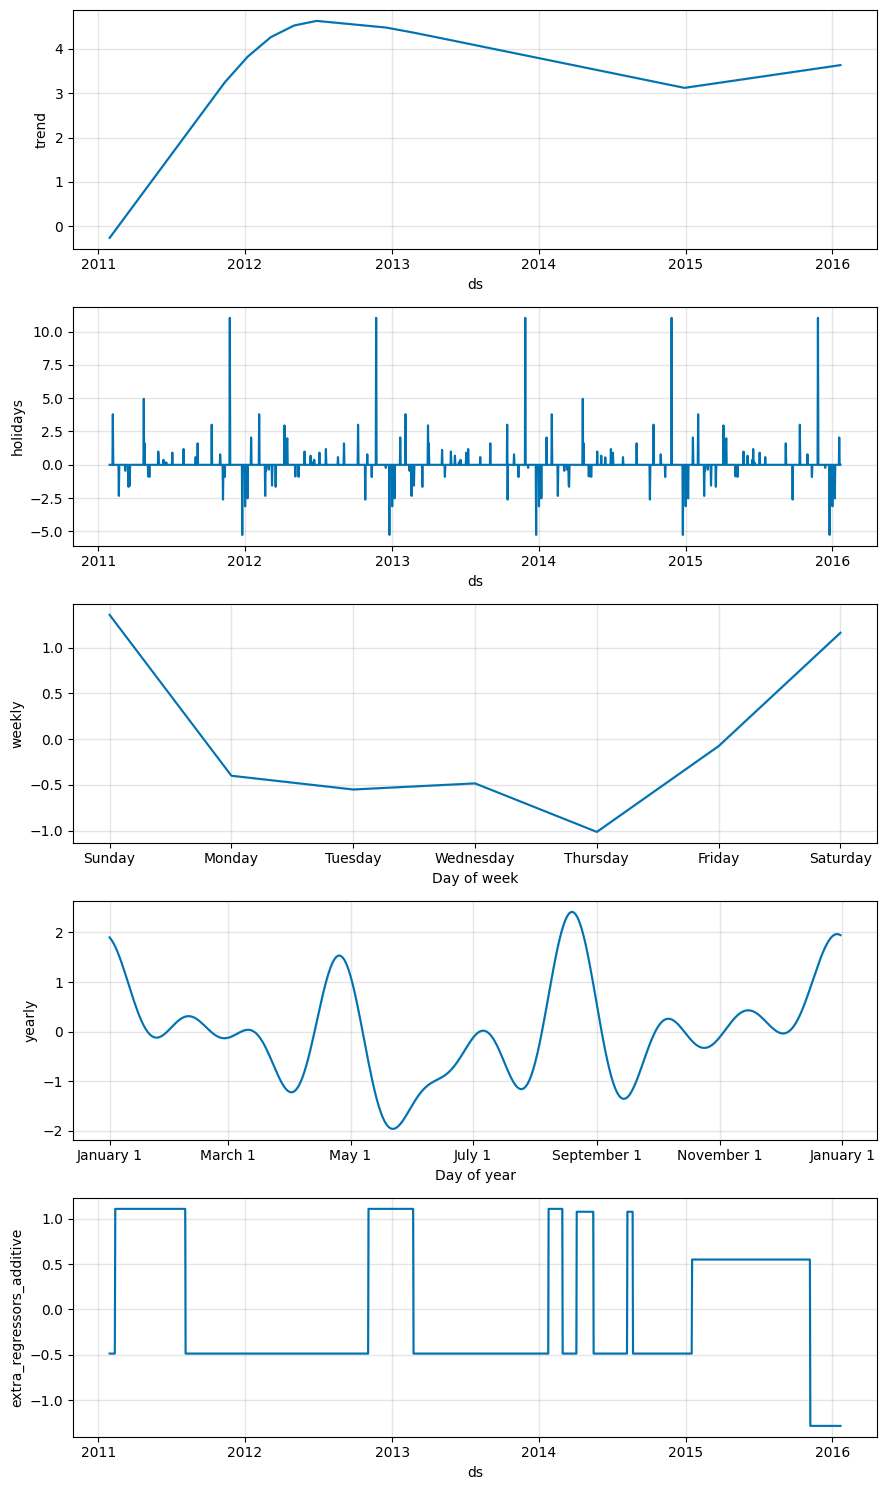

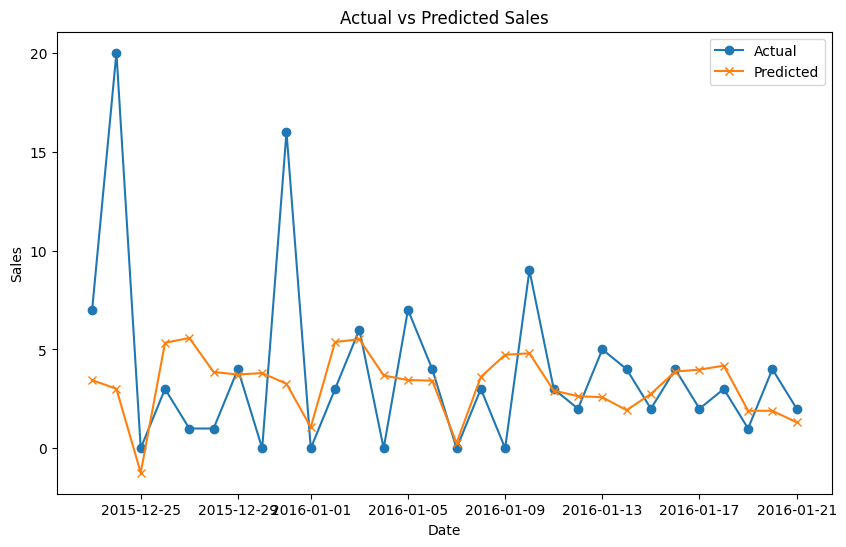

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
19:19:12 

Month - MSE: 20.34673469744964, MAE: 2.7611247853558996, R²: -0.032014271173618436


19:19:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 16.84736830472858
Mean Absolute Error: 2.8345921992315968
R²: -0.37232183495878424


/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


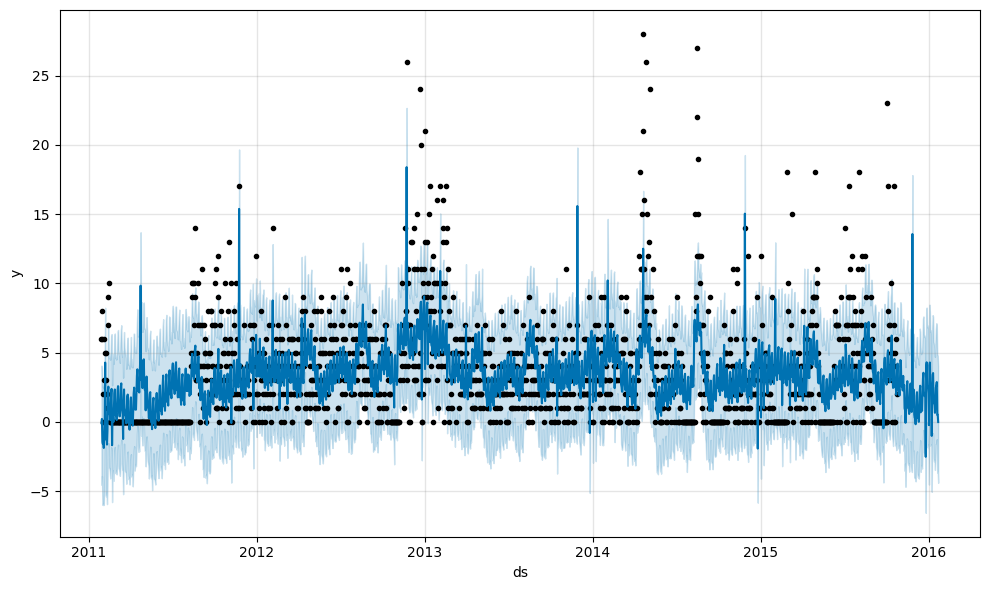

/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

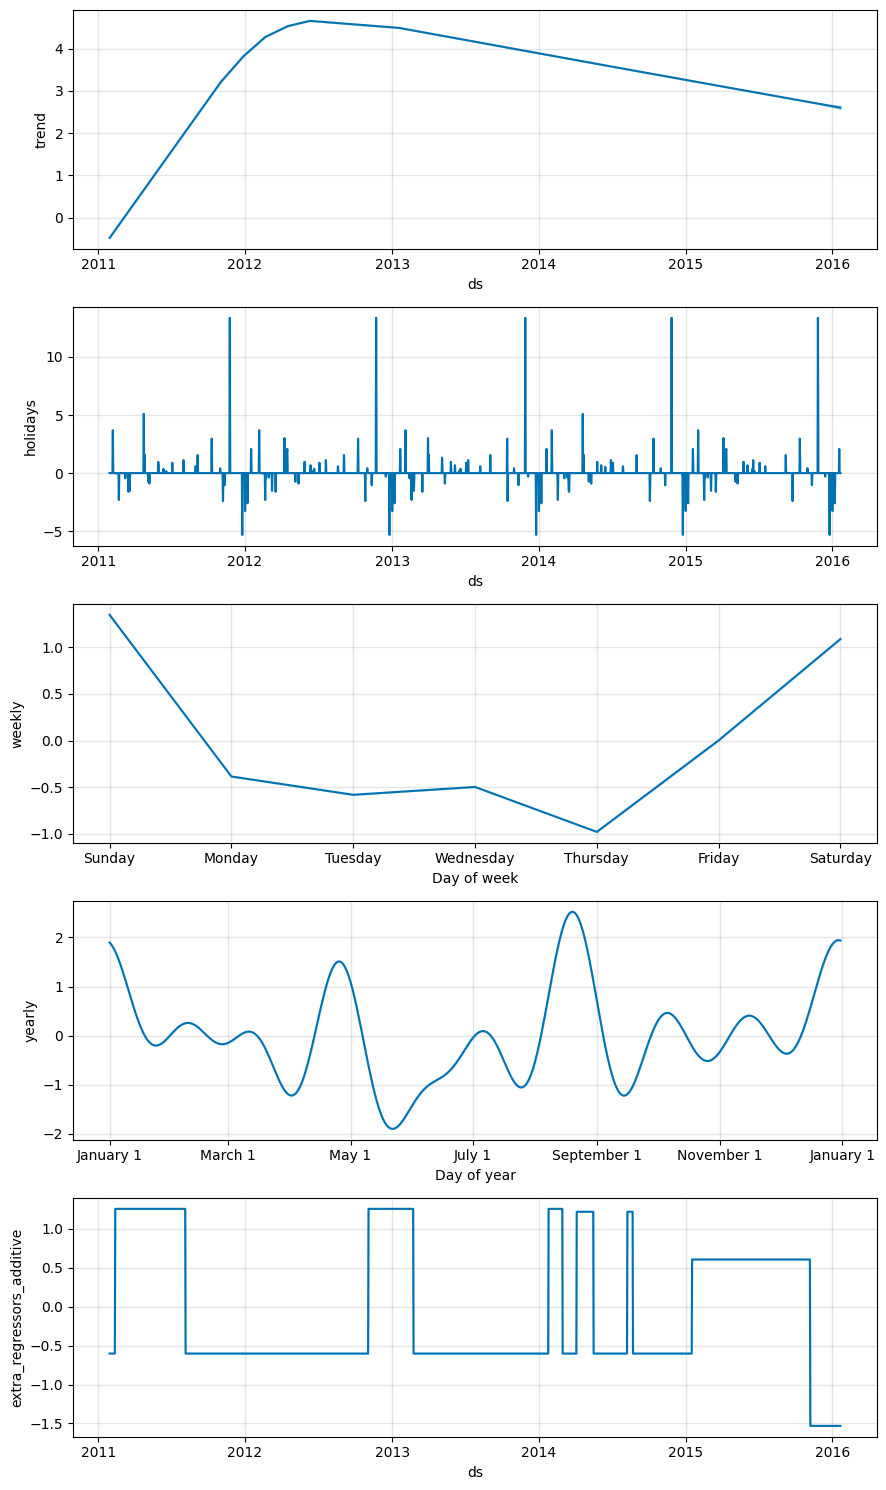

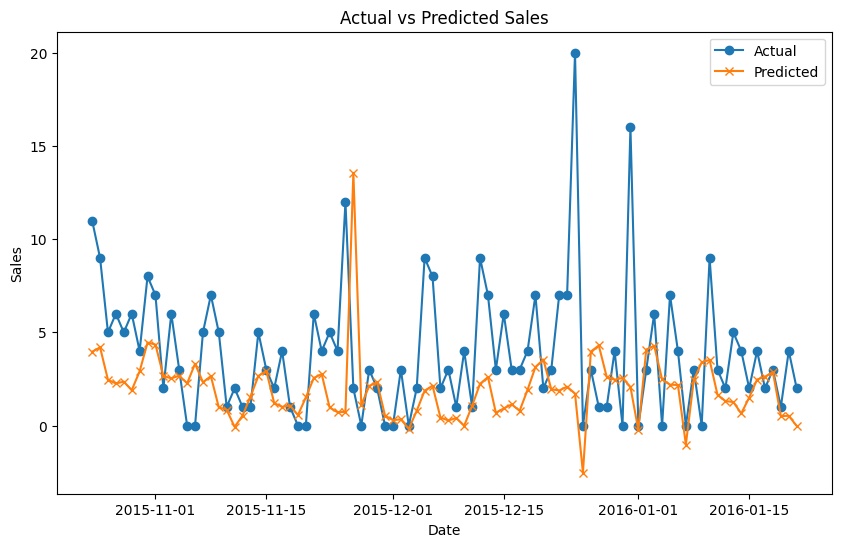

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/fold

Quarter - MSE: 16.84736830472858, MAE: 2.8345921992315968, R²: -0.37232183495878424


19:19:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future['price'].fillna(method='ffill', inplace=True)
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['price'].fillna(method='ffill', inplace=True)
/var/folders/yj/nhkf3nv

Future Week Predictions:              ds      yhat
1819 2016-01-22  2.385390
1820 2016-01-23  3.566477
1821 2016-01-24  3.782399
1822 2016-01-25  1.996448
1823 2016-01-26  1.896793
1824 2016-01-27  1.995549
1825 2016-01-28  1.605841


19:19:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future['price'].fillna(method='ffill', inplace=True)
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['price'].fillna(method='ffill', inplace=True)
/var/folders/yj/nhkf3nv

Future Month Predictions:              ds      yhat
1819 2016-01-22  2.385390
1820 2016-01-23  3.566477
1821 2016-01-24  3.782399
1822 2016-01-25  1.996448
1823 2016-01-26  1.896793
1824 2016-01-27  1.995549
1825 2016-01-28  1.605841
1826 2016-01-29  2.442361
1827 2016-01-30  3.689669
1828 2016-01-31  3.962487
1829 2016-02-01  2.223146
1830 2016-02-02  2.159134
1831 2016-02-03  2.282174
1832 2016-02-04  1.905301
1833 2016-02-05  2.743414
1834 2016-02-06  3.981565
1835 2016-02-07  4.235244
1836 2016-02-08  2.467790
1837 2016-02-09  2.367923
1838 2016-02-10  2.448773
1839 2016-02-11  2.024927
1840 2016-02-12  2.812925
1841 2016-02-13  3.999514
1842 2016-02-14  4.201874
1843 2016-02-15  2.384992
1844 2016-02-16  2.239136
1845 2016-02-17  2.278847
1846 2016-02-18  1.819945
1847 2016-02-19  2.579988
1848 2016-02-20  3.746500


19:19:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future['price'].fillna(method='ffill', inplace=True)
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/685021733.py:142: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['price'].fillna(method='ffill', inplace=True)


Future Quarter Predictions:              ds      yhat
1819 2016-01-22  2.385390
1820 2016-01-23  3.566477
1821 2016-01-24  3.782399
1822 2016-01-25  1.996448
1823 2016-01-26  1.896793
...         ...       ...
1904 2016-04-16  4.415010
1905 2016-04-17  4.818882
1906 2016-04-18  3.197994
1907 2016-04-19  3.238315
1908 2016-04-20  3.450202

[90 rows x 2 columns]


In [58]:
# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Создание экземпляра класса RetailSalesPredictor
predictor = RetailSalesPredictor(sales_data, calendar_data, prices_data)

# Оценка качества модели на тестовой выборке
model_week, mse_week, mae_week, r2_week = predictor.forecast_week('STORE_1', 'STORE_1_727')
print(f'Week - MSE: {mse_week}, MAE: {mae_week}, R²: {r2_week}')

model_month, mse_month, mae_month, r2_month = predictor.forecast_month('STORE_1', 'STORE_1_727')
print(f'Month - MSE: {mse_month}, MAE: {mae_month}, R²: {r2_month}')

model_quarter, mse_quarter, mae_quarter, r2_quarter = predictor.forecast_quarter('STORE_1', 'STORE_1_727')
print(f'Quarter - MSE: {mse_quarter}, MAE: {mae_quarter}, R²: {r2_quarter}')

# Предсказание будущих значений
future_week = predictor.predict_week('STORE_1', 'STORE_1_727')
print(f'Future Week Predictions: {future_week}')

future_month = predictor.predict_month('STORE_1', 'STORE_1_727')
print(f'Future Month Predictions: {future_month}')

future_quarter = predictor.predict_quarter('STORE_1', 'STORE_1_727')
print(f'Future Quarter Predictions: {future_quarter}')

# Сохранение модели
predictor.save_model(model_week, 'model_week.pkl')
predictor.save_model(model_month, 'model_month.pkl')
predictor.save_model(model_quarter, 'model_quarter.pkl')

# Загрузка модели
loaded_model_week = predictor.load_model('model_week.pkl')
loaded_model_month = predictor.load_model('model_month.pkl')
loaded_model_quarter = predictor.load_model('model_quarter.pkl')


# SARIMA

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os

class RetailSalesPredictorSARIMA:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data

    def preprocess_data(self, store_id, item_id):
        sales = self.sales_data[(self.sales_data['store_id'] == store_id) & (self.sales_data['item_id'] == item_id)]
        sales = pd.merge(sales, self.calendar_data, on='date_id', how='inner')
        sales = sales.rename(columns={'date': 'ds', 'cnt': 'y'})
        sales['ds'] = pd.to_datetime(sales['ds'])
        sales.set_index('ds', inplace=True)

        item_prices = self.prices_data[self.prices_data['item_id'] == item_id][['wm_yr_wk', 'sell_price']]
        item_prices['wm_yr_wk'] = item_prices['wm_yr_wk'].astype(int)
        item_prices = item_prices.rename(columns={'wm_yr_wk': 'week', 'sell_price': 'price'})
        self.calendar_data['wm_yr_wk'] = self.calendar_data['wm_yr_wk'].astype(int)
        item_prices = item_prices.merge(self.calendar_data[['wm_yr_wk', 'date']], left_on='week', right_on='wm_yr_wk', how='left')
        item_prices = item_prices.rename(columns={'date': 'ds'}).drop(columns=['wm_yr_wk'])
        item_prices['ds'] = pd.to_datetime(item_prices['ds'])
        item_prices.set_index('ds', inplace=True)

        # Handling missing values in price column
        item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values

        sales = sales.merge(item_prices[['price']], on='ds', how='left')

        return sales

    def train_model(self, sales_data, test_size=30):
        if len(sales_data) <= test_size:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        train_data = sales_data.iloc[:-test_size]
        test_data = sales_data.iloc[-test_size:]

        if len(train_data) < 2:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        model = SARIMAX(train_data['y'], exog=train_data[['price']], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)

        return model_fit, train_data, test_data

    def predict_and_evaluate(self, model, test_data):
        future_exog = test_data[['price']]
        predicted_values = model.predict(start=test_data.index[0], end=test_data.index[-1], exog=future_exog)

        actual = test_data['y'].values
        predicted_values = predicted_values.values

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)
        r2 = r2_score(actual, predicted_values)

        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'R²: {r2}')

        # Визуализация тестовой части и предсказанных данных
        plt.figure(figsize=(10, 6))
        plt.plot(test_data.index, actual, label='Actual', marker='o')
        plt.plot(test_data.index, predicted_values, label='Predicted', marker='x')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

        return mse, mae, r2

    def save_model(self, model, filename):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model

    def forecast_period(self, store_id, item_id, period):
        sales_data = self.preprocess_data(store_id, item_id)
        available_data = len(sales_data)
        test_size = min(period, available_data - 2)  # Убедимся, что у нас достаточно данных для тренировки и тестирования
        if test_size < 1:
            raise ValueError("Not enough data to train the model for this period. Please provide more data.")
        model, train_data, test_data = self.train_model(sales_data, test_size=test_size)
        mse, mae, r2 = self.predict_and_evaluate(model, test_data)
        return model, mse, mae, r2

    def forecast_future(self, store_id, item_id, period):
        sales_data = self.preprocess_data(store_id, item_id)
        if len(sales_data) < 2:
            raise ValueError("Not enough data to forecast the future.")
        
        train_data = sales_data.copy()
        model = SARIMAX(train_data['y'], exog=train_data[['price']], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)
        
        future_dates = pd.date_range(start=sales_data.index[-1], periods=period + 1, freq='D')[1:]
        future_exog = sales_data[['price']].reindex(future_dates).fillna(method='ffill')

        forecast = model_fit.predict(start=future_dates[0], end=future_dates[-1], exog=future_exog)
        
        return forecast

    def forecast_week(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=7)

    def forecast_month(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=30)

    def forecast_quarter(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=90)

    def predict_week(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=7)

    def predict_month(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=30)

    def predict_quarter(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=90)


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/Users/mu

Mean Squared Error: 3.393098608241345
Mean Absolute Error: 1.5086662133584017
R²: -2.0789228111819607


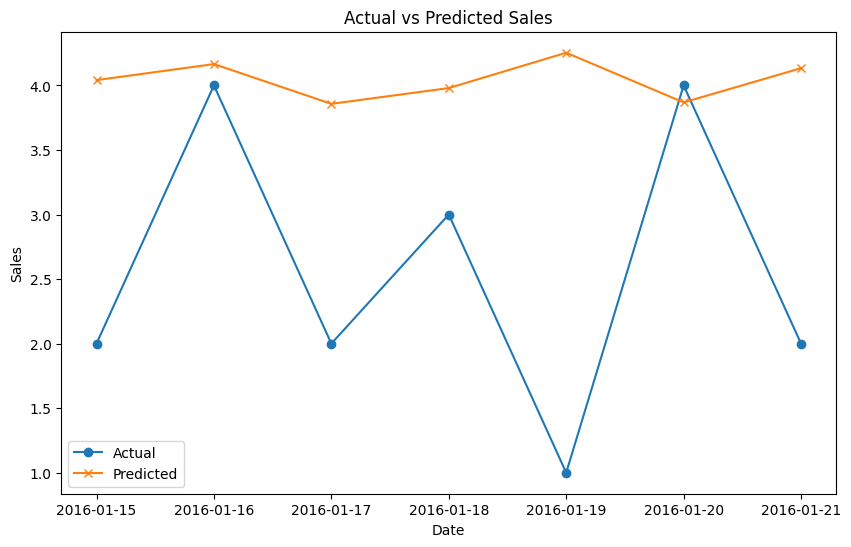

Week - MSE: 3.393098608241345, MAE: 1.5086662133584017, R²: -2.0789228111819607


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/Users/mu

Mean Squared Error: 20.45189365596009
Mean Absolute Error: 3.1809503418177383
R²: -0.03734807768057302


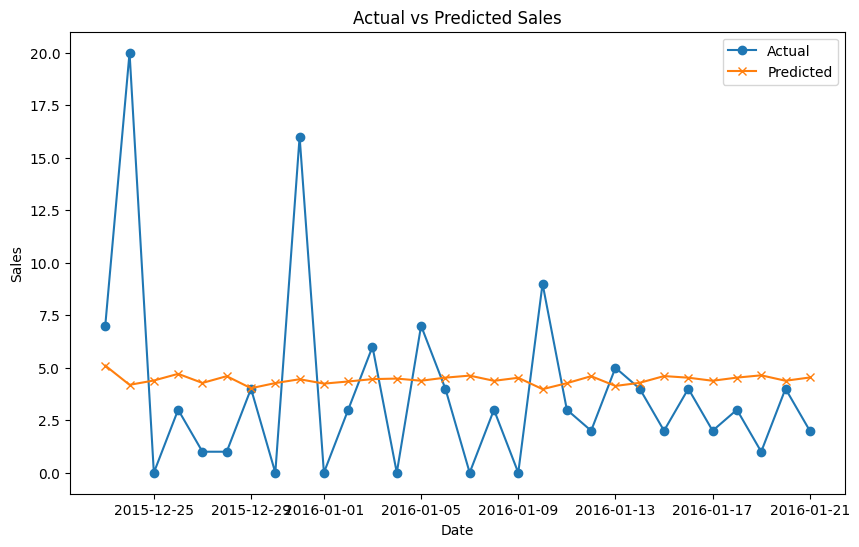

Month - MSE: 20.45189365596009, MAE: 3.1809503418177383, R²: -0.03734807768057302


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/Users/mu

Mean Squared Error: 13.692260988020687
Mean Absolute Error: 2.5160160783477195
R²: -0.11531892601536176


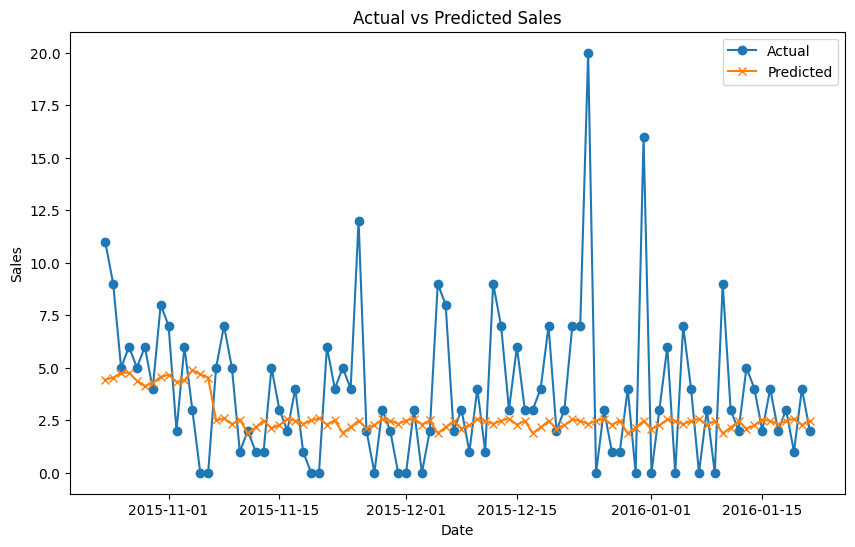

Quarter - MSE: 13.692260988020687, MAE: 2.5160160783477195, R²: -0.11531892601536176


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/232186184.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/Users/mu

MissingDataError: exog contains inf or nans

In [60]:
# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Создание объекта предсказателя
predictor = RetailSalesPredictorSARIMA(sales_data, calendar_data, prices_data)

# Оценка качества модели на тестовой выборке
model_week, mse_week, mae_week, r2_week = predictor.forecast_week('STORE_1', 'STORE_1_727')
print(f'Week - MSE: {mse_week}, MAE: {mae_week}, R²: {r2_week}')

model_month, mse_month, mae_month, r2_month = predictor.forecast_month('STORE_1', 'STORE_1_727')
print(f'Month - MSE: {mse_month}, MAE: {mae_month}, R²: {r2_month}')

model_quarter, mse_quarter, mae_quarter, r2_quarter = predictor.forecast_quarter('STORE_1', 'STORE_1_727')
print(f'Quarter - MSE: {mse_quarter}, MAE: {mae_quarter}, R²: {r2_quarter}')

# Предсказание будущих значений
future_week = predictor.predict_week('STORE_1', 'STORE_1_727')
print(f'Future Week Predictions: {future_week}')

future_month = predictor.predict_month('STORE_1', 'STORE_1_727')
print(f'Future Month Predictions: {future_month}')

future_quarter = predictor.predict_quarter('STORE_1', 'STORE_1_727')
print(f'Future Quarter Predictions: {future_quarter}')

# Сохранение модели
predictor.save_model(model_week, 'model_week_sarima.pkl')
predictor.save_model(model_month, 'model_month_sarima.pkl')
predictor.save_model(model_quarter, 'model_quarter_sarima.pkl')

# Загрузка модели
loaded_model_week = predictor.load_model('model_week_sarima.pkl')
loaded_model_month = predictor.load_model('model_month_sarima.pkl')
loaded_model_quarter = predictor.load_model('model_quarter_sarima.pkl')


# Автоматический подбор параметров SARIMA с использованием pmdarima

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os

class RetailSalesPredictorSARIMA:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data

    def preprocess_data(self, store_id, item_id):
        sales = self.sales_data[(self.sales_data['store_id'] == store_id) & (self.sales_data['item_id'] == item_id)]
        sales = pd.merge(sales, self.calendar_data, on='date_id', how='inner')
        sales = sales.rename(columns={'date': 'ds', 'cnt': 'y'})
        sales['ds'] = pd.to_datetime(sales['ds'])
        sales.set_index('ds', inplace=True)

        item_prices = self.prices_data[self.prices_data['item_id'] == item_id][['wm_yr_wk', 'sell_price']]
        item_prices['wm_yr_wk'] = item_prices['wm_yr_wk'].astype(int)
        item_prices = item_prices.rename(columns={'wm_yr_wk': 'week', 'sell_price': 'price'})
        self.calendar_data['wm_yr_wk'] = self.calendar_data['wm_yr_wk'].astype(int)
        item_prices = item_prices.merge(self.calendar_data[['wm_yr_wk', 'date']], left_on='week', right_on='wm_yr_wk', how='left')
        item_prices = item_prices.rename(columns={'date': 'ds'}).drop(columns=['wm_yr_wk'])
        item_prices['ds'] = pd.to_datetime(item_prices['ds'])
        item_prices.set_index('ds', inplace=True)

        # Handling missing values in price column
        item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values

        sales = sales.merge(item_prices[['price']], on='ds', how='left')

        return sales

    def train_model(self, sales_data, test_size=30):
        if len(sales_data) <= test_size:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        train_data = sales_data.iloc[:-test_size]
        test_data = sales_data.iloc[-test_size:]

        if len(train_data) < 2:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        # Auto ARIMA model
        model = auto_arima(train_data['y'], exogenous=train_data[['price']], seasonal=True, m=12, trace=True)
        model_fit = model.fit(train_data['y'], exogenous=train_data[['price']])

        return model_fit, train_data, test_data

    def predict_and_evaluate(self, model, test_data):
        future_exog = test_data[['price']]
        predicted_values = model.predict(n_periods=len(test_data), exogenous=future_exog)

        actual = test_data['y'].values
        predicted_values = predicted_values

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)
        r2 = r2_score(actual, predicted_values)

        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'R²: {r2}')

        # Визуализация тестовой части и предсказанных данных
        plt.figure(figsize=(10, 6))
        plt.plot(test_data.index, actual, label='Actual', marker='o')
        plt.plot(test_data.index, predicted_values, label='Predicted', marker='x')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

        return mse, mae, r2

    def save_model(self, model, filename):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model

    def forecast_period(self, store_id, item_id, period):
        sales_data = self.preprocess_data(store_id, item_id)
        available_data = len(sales_data)
        test_size = min(period, available_data - 2)  # Убедимся, что у нас достаточно данных для тренировки и тестирования
        if test_size < 1:
            raise ValueError("Not enough data to train the model for this period. Please provide more data.")
        model, train_data, test_data = self.train_model(sales_data, test_size=test_size)
        mse, mae, r2 = self.predict_and_evaluate(model, test_data)
        return model, mse, mae, r2

    def forecast_future(self, store_id, item_id, period):
        sales_data = self.preprocess_data(store_id, item_id)
        if len(sales_data) < 2:
            raise ValueError("Not enough data to forecast the future.")
        
        train_data = sales_data.copy()
        model = auto_arima(train_data['y'], exogenous=train_data[['price']], seasonal=True, m=12, trace=True)
        model_fit = model.fit(train_data['y'], exogenous=train_data[['price']])
        
        future_dates = pd.date_range(start=sales_data.index[-1], periods=period + 1, freq='D')[1:]
        future_exog = sales_data[['price']].reindex(future_dates).fillna(method='ffill')

        forecast = model_fit.predict(n_periods=period, exogenous=future_exog)
        
        return forecast

    def forecast_week(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=7)

    def forecast_month(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=30)

    def forecast_quarter(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=90)

    def predict_week(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=7)

    def predict_month(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=30)

    def predict_quarter(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=90)


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/3854820795.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/3854820795.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9375.295, Time=4.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10099.006, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9737.877, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9400.155, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10097.007, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9376.339, Time=1.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9376.599, Time=1.69 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=9378.928, Time=5.63 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9378.978, Time=5.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9378.761, Time=0.36 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9376.982, Time=4.45 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=9376.931, Time=5.09 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=11.43 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=9376.237, Time=3.68 sec
 ARIMA(2,1,1)(1,0,1)[

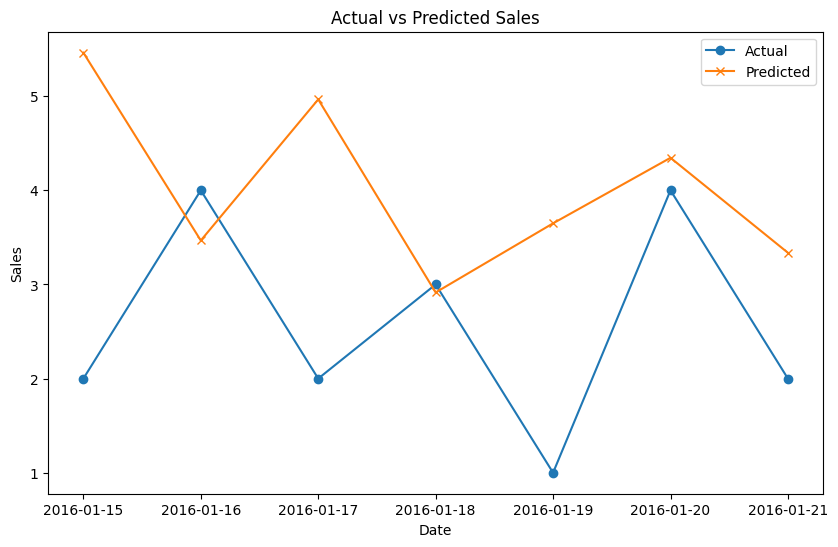

Week - MSE: 4.284981700468579, MAE: 1.6252582757793645, R²: -2.8882241356103773
Performing stepwise search to minimize aic


/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/3854820795.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_28943/3854820795.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_prices['price'].fillna(method='ffill', inplace=True)  # Forward fill missing values


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9207.960, Time=3.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9902.229, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9561.603, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9235.907, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9900.229, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9208.405, Time=1.56 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9208.767, Time=1.19 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=9209.516, Time=9.31 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9209.500, Time=9.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9212.899, Time=0.27 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9209.263, Time=3.34 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=9209.290, Time=3.02 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=9211.525, Time=12.00 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=9211.630, Time=5.39 sec

KeyboardInterrupt: 

In [62]:
# Использование класса
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

predictor_sarima = RetailSalesPredictorSARIMA(sales_data, calendar_data, prices_data)

# Оценка качества модели на тестовой выборке
model_week, mse_week, mae_week, r2_week = predictor_sarima.forecast_week('STORE_1', 'STORE_1_727')
print(f'Week - MSE: {mse_week}, MAE: {mae_week}, R²: {r2_week}')

model_month, mse_month, mae_month, r2_month = predictor_sarima.forecast_month('STORE_1', 'STORE_1_727')
print(f'Month - MSE: {mse_month}, MAE: {mae_month}, R²: {r2_month}')

model_quarter, mse_quarter, mae_quarter, r2_quarter = predictor_sarima.forecast_quarter('STORE_1', 'STORE_1_727')
print(f'Quarter - MSE: {mse_quarter}, MAE: {mae_quarter}, R²: {r2_quarter}')

# Предсказание будущих значений
future_week = predictor_sarima.predict_week('STORE_1', 'STORE_1_727')
print(f'Future Week Predictions: {future_week}')

future_month = predictor_sarima.predict_month('STORE_1', 'STORE_1_727')
print(f'Future Month Predictions: {future_month}')

future_quarter = predictor_sarima.predict_quarter('STORE_1', 'STORE_1_727')
print(f'Future Quarter Predictions: {future_quarter}')

# Сохранение модели
predictor_sarima.save_model(model_week, 'model_week_sarima.pkl')
predictor_sarima.save_model(model_month, 'model_month_sarima.pkl')
predictor_sarima.save_model(model_quarter, 'model_quarter_sarima.pkl')

# Загрузка модели
loaded_model_week = predictor_sarima.load_model('model_week_sarima.pkl')
loaded_model_month = predictor_sarima.load_model('model_month_sarima.pkl')
loaded_model_quarter = predictor_sarima.load_model('model_quarter_sarima.pkl')


# Пробуем поэтапно без создания классов

In [96]:
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

In [90]:
sales_data = sales_data[(sales_data['store_id'] == 'STORE_1') & (sales_data['item_id'] == 'STORE_1_252')]
sales_data

,item_id,store_id,date_id,cnt
63665,STORE_1_252,STORE_1,1,22
63666,STORE_1_252,STORE_1,2,23
63667,STORE_1_252,STORE_1,3,12
63668,STORE_1_252,STORE_1,4,12
63669,STORE_1_252,STORE_1,5,8
...,...,...,...,...
65479,STORE_1_252,STORE_1,1815,13
65480,STORE_1_252,STORE_1,1816,2
65481,STORE_1_252,STORE_1,1817,8
65482,STORE_1_252,STORE_1,1818,13


In [91]:
prices_data

,store_id,item_id,wm_yr_wk,sell_price
0,STORE_2,STORE_2_085,11101,1.00
1,STORE_2,STORE_2_043,11101,2.88
2,STORE_2,STORE_2_054,11101,2.28
3,STORE_2,STORE_2_090,11101,1.25
4,STORE_2,STORE_2_252,11101,1.48
...,...,...,...,...
11136,STORE_1,STORE_1_584,11551,1.00
11137,STORE_1,STORE_1_586,11551,1.68
11138,STORE_1,STORE_1_587,11551,2.48
11139,STORE_1,STORE_1_714,11551,1.58


In [93]:
sales_data = pd.merge(sales_data, prices_data, on=['item_id','store_id'] , how='inner')
sales_data

,item_id,store_id,date_id,cnt,wm_yr_wk,sell_price
0,STORE_1_252,STORE_1,1,22,11101,1.48
1,STORE_1_252,STORE_1,1,22,11102,1.48
2,STORE_1_252,STORE_1,1,22,11103,1.48
3,STORE_1_252,STORE_1,1,22,11104,1.48
4,STORE_1_252,STORE_1,1,22,11105,1.48
...,...,...,...,...,...,...
472935,STORE_1_252,STORE_1,1819,1,11547,1.58
472936,STORE_1_252,STORE_1,1819,1,11548,1.58
472937,STORE_1_252,STORE_1,1819,1,11549,1.58
472938,STORE_1_252,STORE_1,1819,1,11550,1.58


In [86]:
sales_data = pd.merge(sales_data, calendar_data, on='date_id', how='inner')
sales_data

,item_id,store_id_x,date_id,cnt,store_id_y,wm_yr_wk_x,sell_price,date,wm_yr_wk_y,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
0,STORE_1_252,STORE_1,1,22,STORE_1,11101,1.48,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,STORE_1_252,STORE_1,1,22,STORE_1,11102,1.48,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,STORE_1_252,STORE_1,1,22,STORE_1,11103,1.48,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,STORE_1_252,STORE_1,1,22,STORE_1,11104,1.48,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,STORE_1_252,STORE_1,1,22,STORE_1,11105,1.48,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472935,STORE_1_252,STORE_1,1819,1,STORE_1,11547,1.58,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,0,0,0
472936,STORE_1_252,STORE_1,1819,1,STORE_1,11548,1.58,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,0,0,0
472937,STORE_1_252,STORE_1,1819,1,STORE_1,11549,1.58,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,0,0,0
472938,STORE_1_252,STORE_1,1819,1,STORE_1,11550,1.58,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,0,0,0


In [88]:
sales_data['event_name_1'].value_counts()

event_name_1
SuperBowl              1300
ValentinesDay          1300
MartinLutherKingDay    1300
OrthodoxChristmas      1300
NewYear                1300
Chanukah End           1300
Christmas              1300
Thanksgiving           1300
VeteransDay            1300
EidAlAdha              1300
Halloween              1300
ColumbusDay            1300
LaborDay               1300
Eid al-Fitr            1300
Ramadan starts         1300
IndependenceDay        1300
NBAFinalsEnd           1300
NBAFinalsStart         1300
MemorialDay            1300
Mother's day           1300
Pesach End             1300
Purim End              1300
StPatricksDay          1300
LentWeek2              1300
LentStart              1300
PresidentsDay          1300
Father's day           1040
Cinco De Mayo          1040
OrthodoxEaster         1040
Easter                 1040
Name: count, dtype: int64